In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
REGRESSION_DSETS_LARGE_NAMES = data.REGRESSION_DSETS_LARGE_NAMES
import numpy.linalg as npl
from scipy.optimize import minimize
from process_results import process_results, aggregate_results, best_ridge

%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

clustered  decay  gaussian_scale_var  iid  t  thresh


In [133]:
class p:
    seed = 15
    out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/test'
    dset = 'gaussian' # gaussian
    beta_type = 'gaussian' # one_hot
    beta_norm = 1
    iid = 'decay' # 'iid', 'clustered', 'spike', decay
    dset_num = 1 # only matters for pmlb
    dset_name = ''
    reg_param = -1.0 # -1 use csv
    num_features = 100
    n_train_over_num_features = 0.75 # this and num_features sets n_train
    n_test = 100
    noise_std = 1e-1
    noise_distr = 'gaussian' # gaussian, t, gaussian_scale_var, thresh
    model_type = 'ridge' # mdl_orig, 
    cov_param = 2


n_train_over_num_features_list = np.array([1e-2, 5e-2, 1e-1, 0.5, 0.75, 0.9, 1,
                                  1.2, 1.5, 2, 5, 7.5, 1e1, 2e1, 4e1, 1e2])
n = n_train_over_num_features_list.size
r = {
    'mse_norm': np.zeros(n),
    'theta_norm': np.zeros(n),
    'eigensum': np.zeros(n)
}

for i, n_train_over_num_features in tqdm(enumerate(n_train_over_num_features_list)):

    p.n_train = int(n_train_over_num_features * p.num_features)

    # warning - this reseeds!
    X_train, y_train, X_test, y_test, betastar = \
        data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                            noise_std=p.noise_std, noise_distr=p.noise_distr, iid=p.iid, # parameters to be determined
                            beta_type=p.beta_type, beta_norm=p.beta_norm, 
                            seed_for_training_data=p.seed, cov_param=p.cov_param)
    
    eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
    var = p.noise_std**2
    
    def calc_thetahat(l):
        inv = npl.pinv(X_train.T @ X_train + l * np.eye(p.num_features))
        return inv @ X_train.T @ y_train
    
    def mdl1_loss(l):
        thetahat = calc_thetahat(l)
        mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
        theta_norm = npl.norm(thetahat)**2 / (2 * var)
        eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
        return mse_norm + theta_norm + eigensum
    
    opt_solved = minimize(mdl1_loss, x0=1e-10)
    lambda_opt = opt_solved.x
    thetahat = calc_thetahat(lambda_opt)
    r['mse_norm'][i] = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
    r['theta_norm'][i] = npl.norm(thetahat)**2 / (2 * var)
    r['eigensum'][i] = 0.5 * np.sum(np.log((eigenvals + lambda_opt) / lambda_opt))
r['loss_val'] = r['mse_norm'] + r['theta_norm'] + r['eigensum']


0it [00:00, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part

1it [00:00,  4.32it/s]
2it [00:00,  4.36it/s]
3it [00:00,  4.39it/s]
4it [00:00,  3.92it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:489: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[0, 1] = -db ** 2
/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:491: ComplexWarning: Casting complex values to real discards the imaginary part
  d1[1, 1] = db ** 3
/accounts/projects/vision/.local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:488: ComplexWarning: Casting complex 

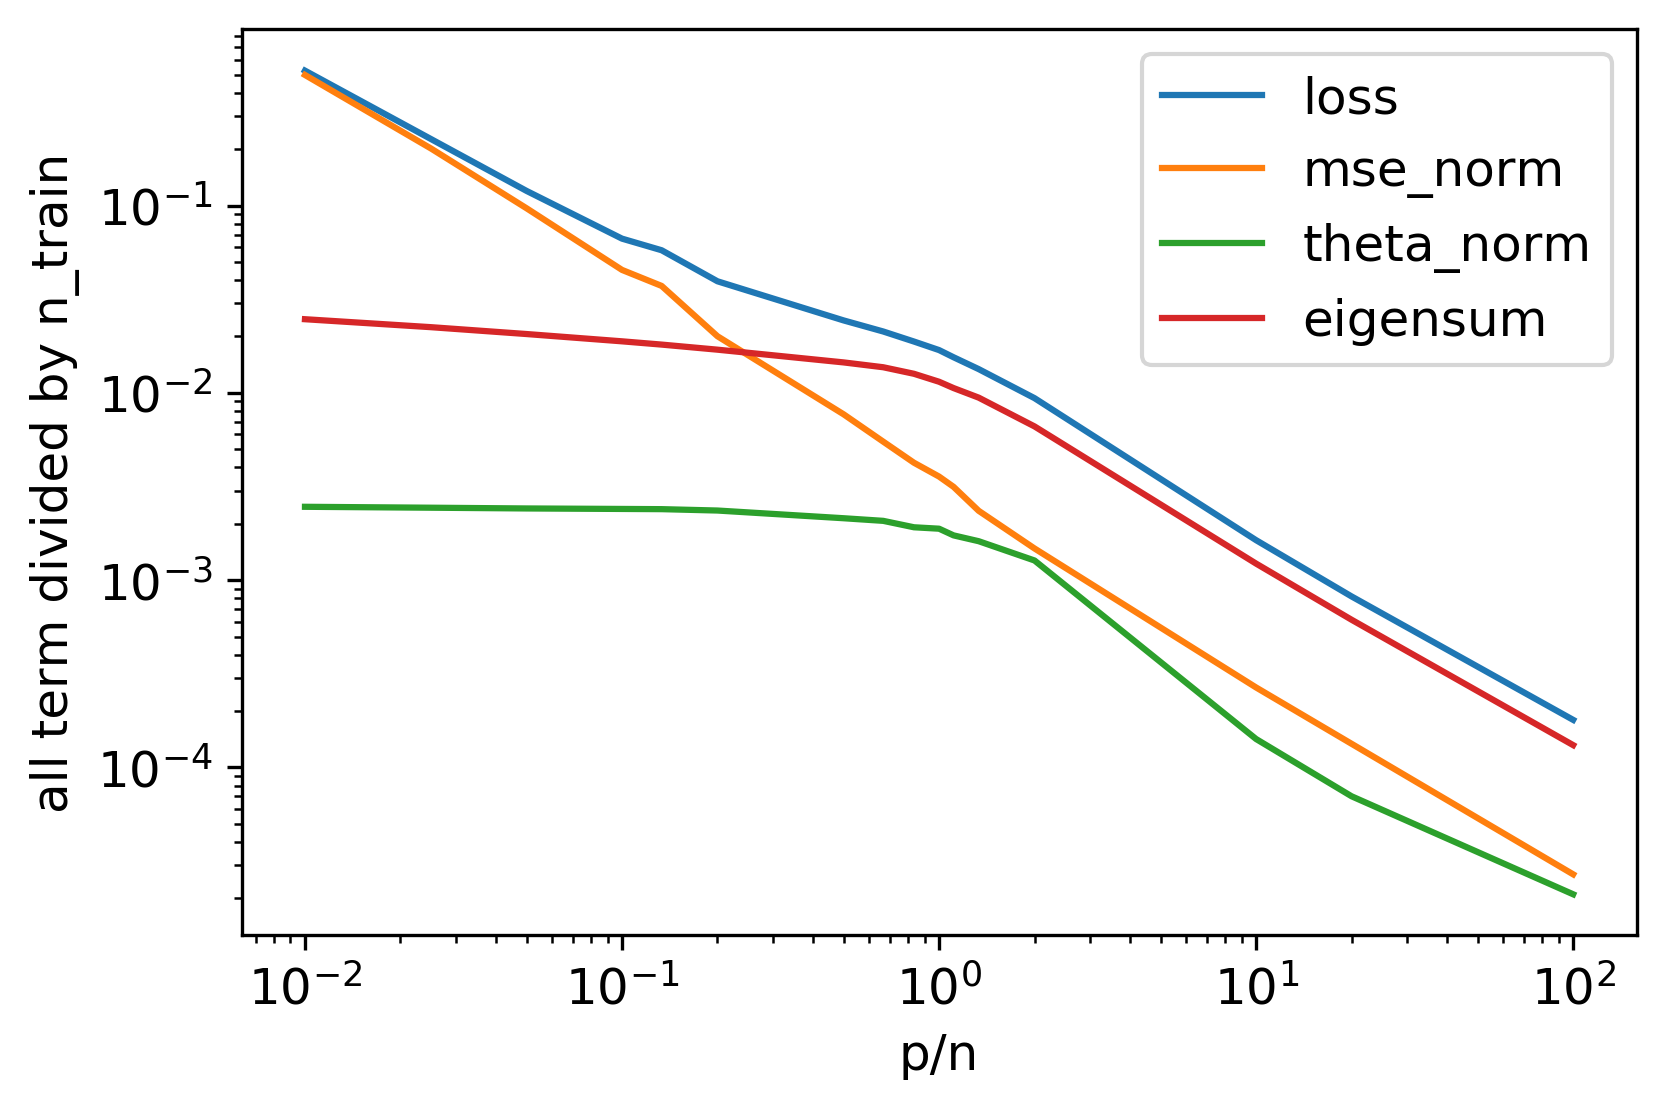

In [131]:
plt.figure(dpi=300)
def norm(x):
    return x / n_train_over_num_features / p.num_features
plt.plot(1/n_train_over_num_features_list, norm(r['loss_val']), label='loss')
plt.plot(1/n_train_over_num_features_list, norm(r['mse_norm']), label='mse_norm')
plt.plot(1/n_train_over_num_features_list, norm(r['theta_norm']), label='theta_norm')
plt.plot(1/n_train_over_num_features_list, norm(r['eigensum']), label='eigensum')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p/n')
plt.ylabel('all term divided by n_train')
plt.legend()
plt.show()

# misc

u shape y shape (200, 200) (200,)
(100,) 100 100


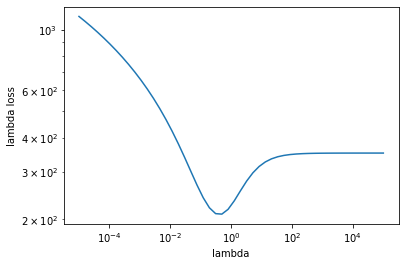

In [49]:
np.random.seed(42)
class p:
    n_train = 200
    num_features = 100
    noise_mult = 0.2
X_train = np.random.randn(p.n_train, p.num_features)
y_train = X_train[:, 0] + X_train[:, 1] + np.random.randn(p.n_train) * p.noise_mult

def lambda_loss(l):
    return np.sum(np.square(a) / (1 + np.square(sv) / l) + np.log(1 + np.square(sv) / l))
U, sv, Vh = npl.svd(X_train / np.sqrt(p.n_train))
print('u shape', 'y shape', U.shape, y_train.shape)
a = U.T @ y_train # / (np.sqrt(p.n_train)) #  np.sqrt(p.noise_mult)
a = a[:sv.size]
print(a.shape, a.size, sv.size)


ls = np.logspace(-5, 5)
plt.loglog(ls, [lambda_loss(l) for l in ls])
plt.ylabel('lambda loss')
plt.xlabel('lambda')
plt.show()

In [52]:
class s:
    pass
s.lambda_opt = minimize(lambda_loss, x0=1e-10).x
inv = npl.pinv(X_train.T @ X_train / p.n_train + s.lambda_opt * np.eye(p.num_features))
s.w = inv @ X_train.T @ y_train / p.n_train

In [54]:
minimize(lambda_loss, x0=1e-10).fun

208.19070669506894